# Imports

In [25]:
import pandas as pd
import os
pd.set_option('display.max_columns', None)

In [66]:
# notice that they have 'target_gender' or 'target_race' prefix, but we'll replace them later
identities = ['target_race_black', 'target_gender_transgender', 'target_gender_men', 'target_gender_women', 'target_race_asian', 'target_race_white']
categories = ['men vs women', 'men vs transgender', 'white vs black', 'white vs asian']
figsize = (14,8)
epsilon_list = [0.5, 1.0, 3.0, 6.0, 9.0]
dataset_name = 'ucberkeley'
dataset_directory = f'../../results/{dataset_name}/'
model_name = 'bert-base-uncased'
output_folder = f'{dataset_directory}/average/{model_name}'
runs = 3
markers = ['+','o', 'v', 's', 'x',  'h', 'D', '^', '>', '<', '*', 'p', 'P',  '.', ]

if not os.path.exists(output_folder):
    os.makedirs(output_folder, exist_ok=True)

# Average bias and overall results

## Load bias and results

In [28]:
bias_df_dict = {}
overall_results_dict = {}

for run in range(1, runs+1):
    run_folder = f'{dataset_directory}/run {run}'
    model_folder = os.path.join(run_folder, model_name)

    normal_folder = os.path.join(model_folder, 'normal')
    bias_df = pd.read_csv(os.path.join(normal_folder, 'global_bias.csv'))
    overall_results = pd.read_csv(os.path.join(normal_folder, 'overall_results.csv'))
    if run ==1:
        bias_df_dict['None'] = [bias_df]
        overall_results_dict['None'] = [overall_results]
    else:
        bias_df_dict['None'].append(bias_df)
        overall_results_dict['None'].append(overall_results)

    for epsilon in epsilon_list:
        dp_folder = os.path.join(model_folder, f'epsilon {epsilon}')
        
        bias_df = pd.read_csv(os.path.join(dp_folder, 'global_bias.csv'))
        overall_results = pd.read_csv(os.path.join(dp_folder, 'overall_results.csv'))

        if run ==1:
            bias_df_dict[epsilon] = [bias_df]
            overall_results_dict[epsilon] = [overall_results]
        else:
            bias_df_dict[epsilon].append(bias_df)
            overall_results_dict[epsilon].append(overall_results)

## Concatenate. Dump average

In [29]:
for epsilon in ['None'] + epsilon_list:
    bias_df_dict[epsilon] = pd.concat(bias_df_dict[epsilon])
    mean = bias_df_dict[epsilon].groupby('fairness_metrics').aggregate('mean').reset_index()
    mean.round(3).to_csv(
        os.path.join(output_folder, f'global_bias_epsilon_{epsilon}.csv'), 
        index=False
    )

    overall_results_dict[epsilon] = pd.concat(overall_results_dict[epsilon])
    mean = overall_results_dict[epsilon].groupby('metrics').aggregate('mean').reset_index()
    mean.round(3).to_csv(
        os.path.join(output_folder, f'overall_results_epsilon_{epsilon}.csv'), 
        index=False
    )

# Plot

In [30]:
import matplotlib.pyplot as plt
import seaborn as sns
# Apply the default theme
sns.set_theme()
sns.set(font_scale = 2)

## Boxplot

In [32]:
dictionary = {
    'Subgroup': [],
    'Metric': [],
    'Train Type': []
}
metric= 'EqOdd'

def key_map(key):
    if key=='None':
        return 'Non-DP'
    return f'ε <={key}'

for identity in identities:
    for key in bias_df_dict.keys():
        bias_df = bias_df_dict[key]
        values = bias_df[bias_df['fairness_metrics']==metric][identity].values
        dictionary['Metric'].extend(values)
        dictionary['Subgroup'].extend([identity]*len(values))
        dictionary['Train Type'].extend([key_map(key)]*len(values))

df = pd.DataFrame(dictionary)

In [41]:
df['Subgroup'] = df['Subgroup'].apply(lambda x: '_'.join(x.split('_')[2:]) if 'target_' in x else x)
temp = []
for identity in identities:
    if 'target_' in identity:
        temp.append('_'.join(identity.split('_')[2:]))
    else:
        temp.append(identity)

identity = temp

In [42]:
hue_order = df['Train Type'].unique()
hue_order = [hue_order[0]] + sorted(hue_order[1:], reverse=True)
hue_order

['Non-DP', 'ε <=9.0', 'ε <=6.0', 'ε <=3.0', 'ε <=1.0', 'ε <=0.5']

In [34]:
# this returns the df with an increasing privacy order of Train type
def order(df):
    return df.set_index('Train Type').reindex(hue_order).reset_index()

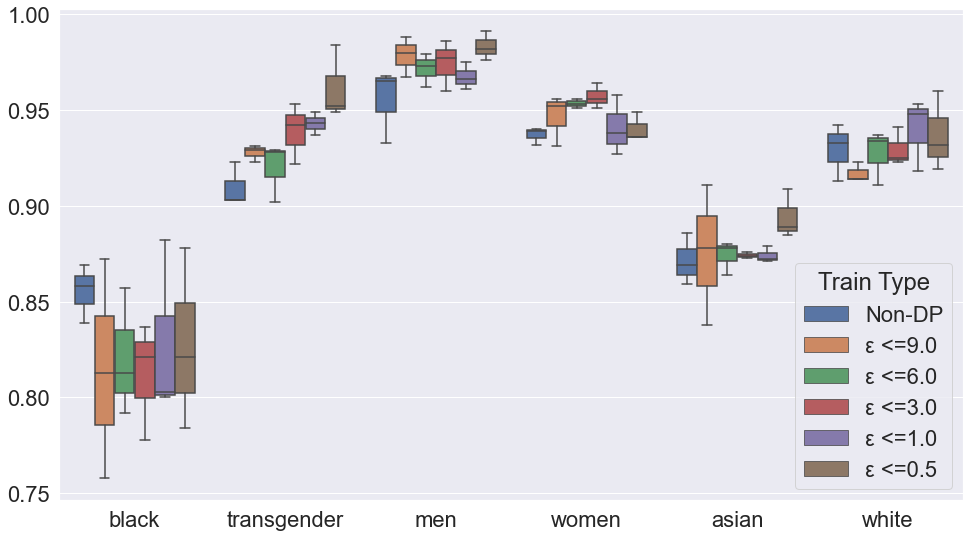

In [43]:
plt.figure(figsize=figsize)
sns.boxplot(x = 'Subgroup', y = 'Metric', hue='Train Type', hue_order=hue_order, data = df)
plt.xlabel('')
plt.ylabel('')
plt.tight_layout()
plt.savefig(os.path.join(output_folder, 'eodds_boxplot.pdf'))

## Overall result

In [67]:
total = []
for epsilon in ['None']+epsilon_list:
    mean = overall_results_dict[epsilon].groupby('metrics').aggregate('mean').reset_index()
    mean['Train Type'] = key_map(epsilon)
    total.append(mean)

In [68]:
total_df = pd.concat(total)
total_df.rename({col:'_'.join(col.split('_')[2:]) for col in total_df.columns if 'target_' in col}, axis=1, inplace=True)
# identities = ['_'.join(identity.split('_')[2:]) for identity in identities]
total_df.head()

,metrics,men,women,transgender,white,black,asian,Total,Train Type
0,accuracy,0.799333,0.755667,0.839333,0.799667,0.821000,0.847000,0.807333,Non-DP
1,auc,0.824333,0.815000,0.879667,0.817333,0.882667,0.857667,0.855333,Non-DP
2,bnsp_auc,0.845000,0.868333,0.807333,0.821333,0.918333,0.769333,NaN,Non-DP
3,bpsn_auc,0.841000,0.820667,0.909667,0.857000,0.811000,0.919667,NaN,Non-DP
4,f1_score,0.582333,0.634000,0.560333,0.569000,0.787333,0.555000,0.647000,Non-DP


In [111]:
total_df[total_df['metrics'].isin(['accuracy', 'f1_score', 'auc'])][['metrics', 'Total', 'Train Type']].round(3)

,metrics,Total,Train Type
0,accuracy,0.807,Non-DP
1,auc,0.855,Non-DP
4,f1_score,0.647,Non-DP
0,accuracy,0.772,ε <=0.5
1,auc,0.790,ε <=0.5
4,f1_score,0.480,ε <=0.5
0,accuracy,0.779,ε <=1.0
1,auc,0.802,ε <=1.0
4,f1_score,0.523,ε <=1.0
0,accuracy,0.785,ε <=3.0


### Total dataset

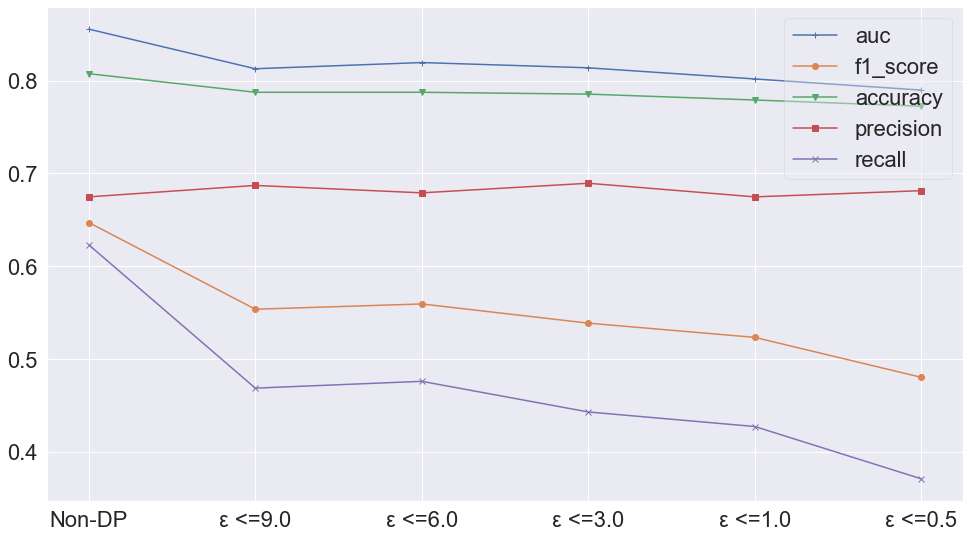

In [46]:
selected_metrics = ['auc', 'f1_score', 'accuracy', 'precision', 'recall']
plt.figure(figsize=figsize)

for i, selected_metric in enumerate(selected_metrics):
    selected_df = total_df[total_df['metrics']==selected_metric]
    selected_df = order(selected_df)
    plt.plot(selected_df["Train Type"], selected_df["Total"], label=selected_metric, marker=markers[i])

plt.legend(loc='upper right', fancybox=True, framealpha=0.4)
plt.tight_layout()
plt.savefig(os.path.join(output_folder, 'overall_total.pdf'))
plt.show()

### Util plot_overall_metric

In [69]:
def plot_overall_metric(selected_metric, title=None, figure_name=None):
    plt.figure(figsize=figsize)
    selected_df = total_df[total_df['metrics']==selected_metric]
    selected_df = order(selected_df)

    for i, identity in enumerate(identities):
        plt.plot(selected_df["Train Type"], selected_df[identity], label=identity, marker=markers[i])

    plt.legend(loc='upper right', fancybox=True, framealpha=0.4)
    if title:
        plt.title(title)
    plt.tight_layout()
    if figure_name:
        plt.savefig(os.path.join(output_folder, figure_name))
    plt.show()

### Recall

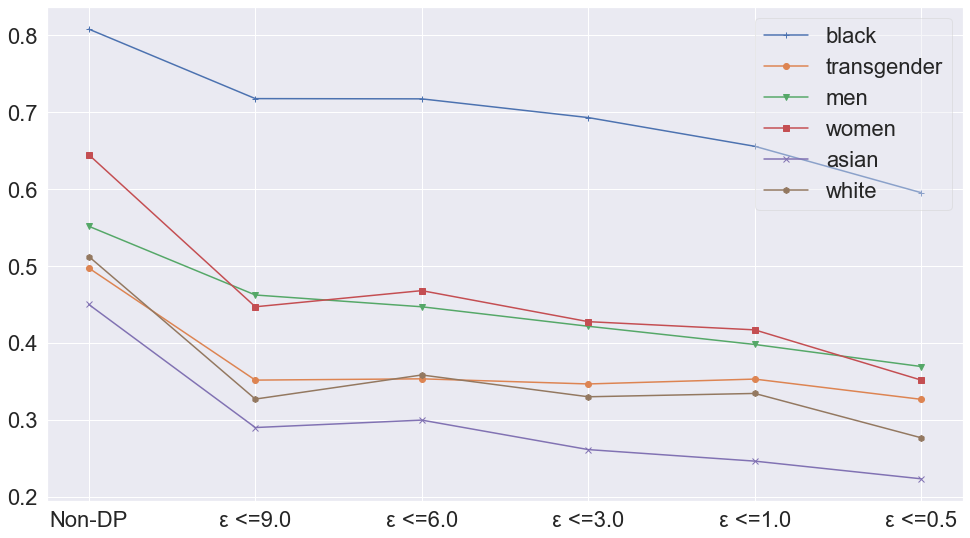

In [70]:
plot_overall_metric('recall')

### BNSP

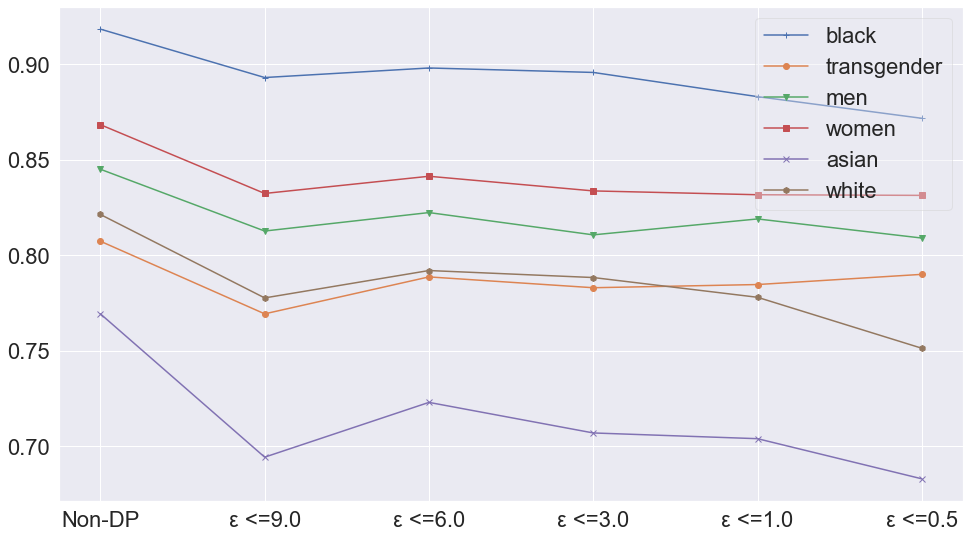

In [114]:
plot_overall_metric('bnsp_auc', figure_name='bnsp.pdf')

### BPSN

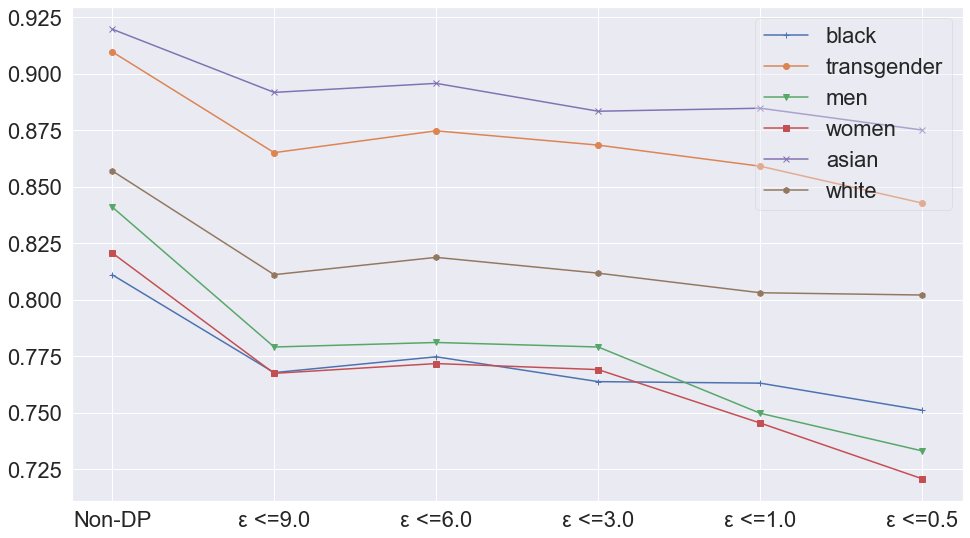

In [115]:
plot_overall_metric('bpsn_auc', figure_name= 'bpsn.pdf')

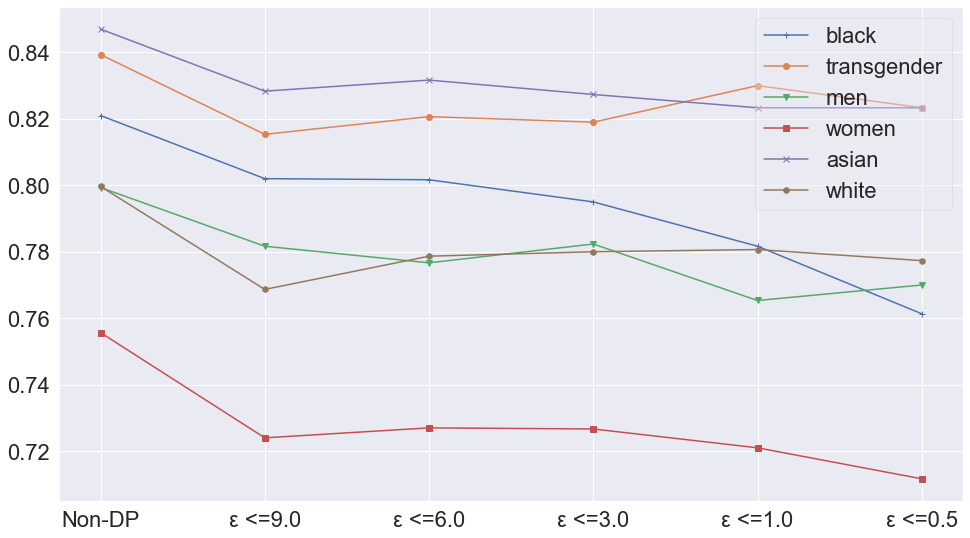

In [116]:
plot_overall_metric('accuracy')

### Subgroup auc

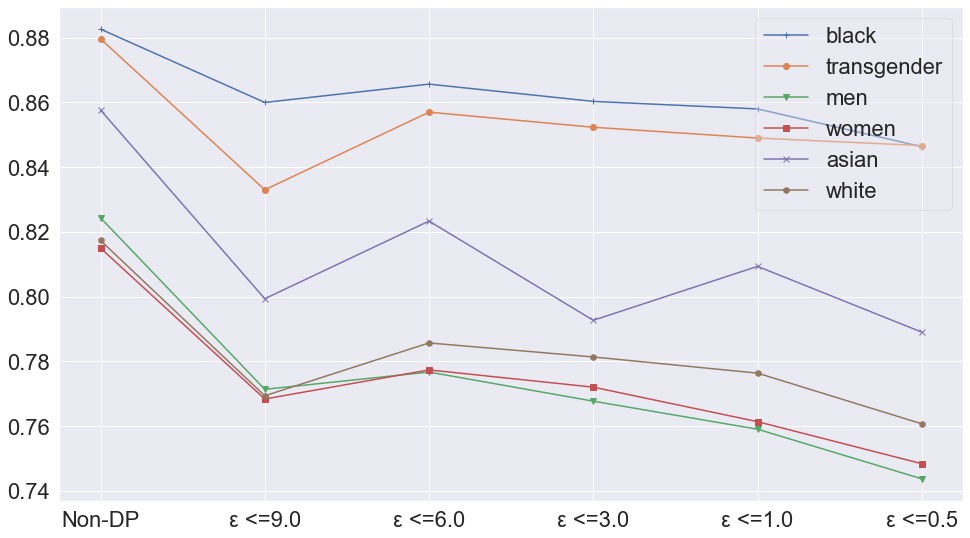

In [117]:
plot_overall_metric('auc', figure_name='roc_auc.pdf')

### F1-score

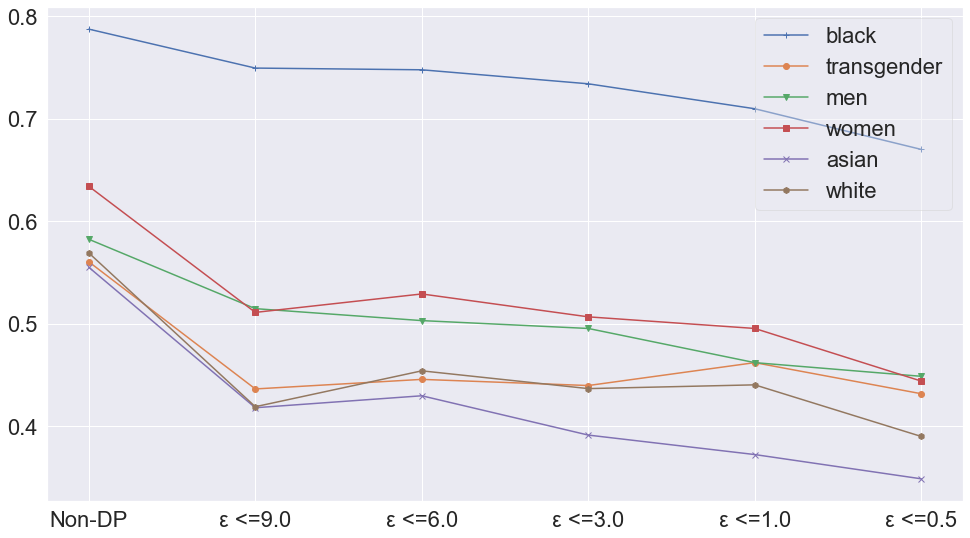

In [118]:
plot_overall_metric('f1_score', figure_name= 'f1_score.pdf')

### False positive rate

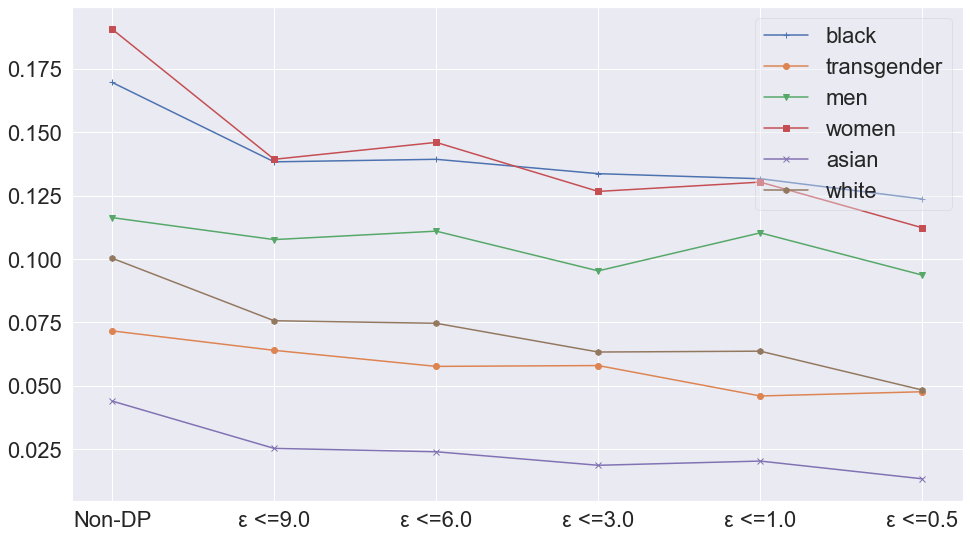

In [119]:
plot_overall_metric('false positive rate', figure_name= 'false_positive_rate.pdf')

## Bias

In [48]:
total = []
for epsilon in ['None']+epsilon_list:
    mean = bias_df_dict[epsilon].groupby('fairness_metrics').aggregate('mean').reset_index()
    mean['Train Type'] = key_map(epsilon)
    total.append(mean)

total_df = pd.concat(total)
total_df.head()

,fairness_metrics,target_gender_women,target_gender_men,target_gender_transgender,target_race_black,target_race_white,target_race_asian,Train Type
0,EqOdd,0.937000,0.955333,0.909667,0.855333,0.929333,0.871333,Non-DP
1,EqOpp0,0.905667,0.990000,0.949000,0.944000,0.978667,0.920667,Non-DP
2,EqOpp1,0.968000,0.920667,0.870333,0.767000,0.880000,0.821333,Non-DP
3,accuracy,0.755667,0.799333,0.839333,0.821000,0.799667,0.847000,Non-DP
4,p-accuracy,0.755667,0.799333,0.839333,0.821000,0.799667,0.847000,Non-DP


In [50]:
total_df.rename({col:'_'.join(col.split('_')[2:]) for col in total_df.columns if 'target_' in col}, axis=1, inplace=True)

### Util plot_bias_metric

In [52]:
def plot_bias_metric(category, title=None, figure_name= None):
    plt.figure(figsize=figsize)
    metric_column = 'fairness_metrics'
    # selected_metrics = total_df[metric_column].unique()
    selected_metrics = ['EqOdd','EqOpp1', 'EqOpp0',  'parity', 'p-accuracy', 'up-accuracy']
    
    for i, selected_metric in enumerate(selected_metrics):
        selected_df = total_df[total_df[metric_column]==selected_metric]
        selected_df = order(selected_df)
        
        plt.plot(selected_df["Train Type"], selected_df[category], label=selected_metric, marker=markers[i])

    plt.legend(loc='upper right', fancybox=True, framealpha=0.5)
    if title:
        plt.title(title)
    plt.tight_layout()
    if figure_name:
        plt.savefig(os.path.join(output_folder, figure_name))

    plt.show()

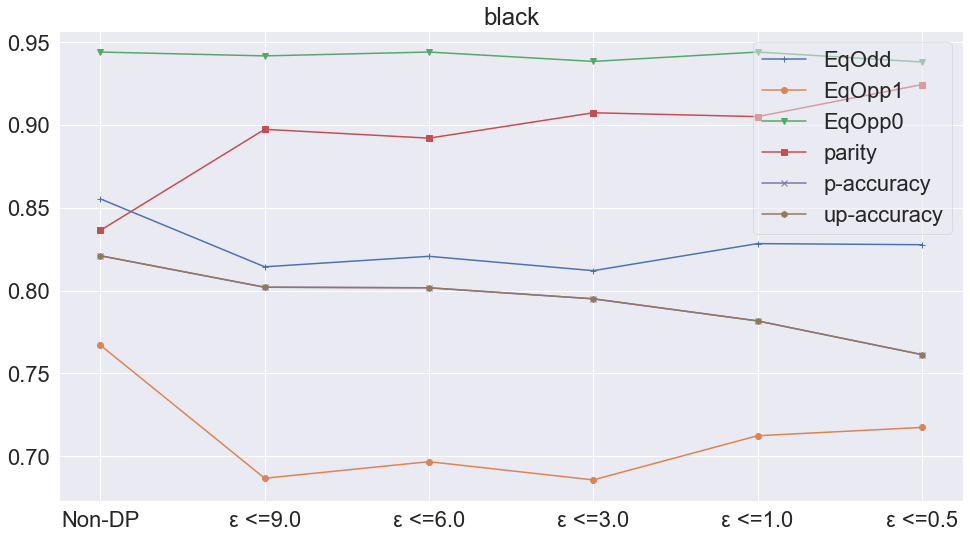

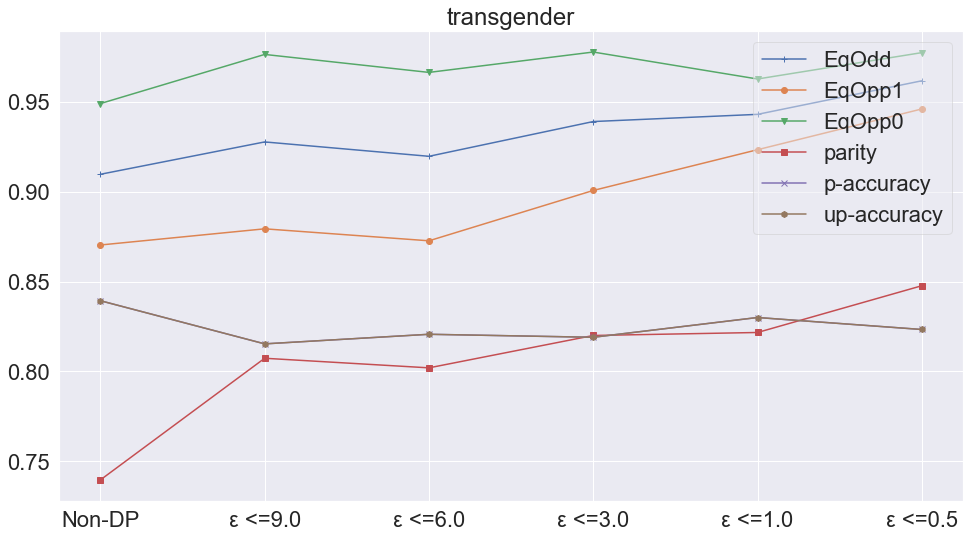

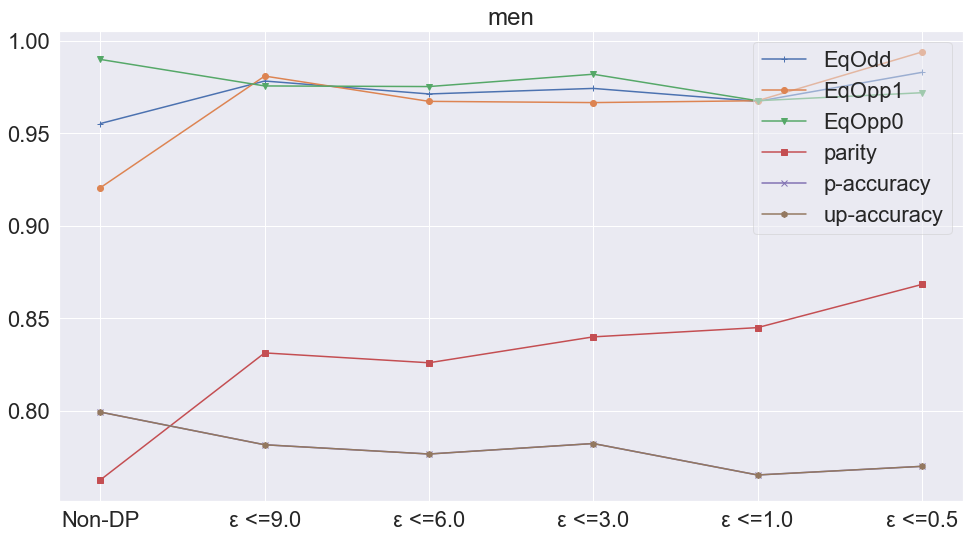

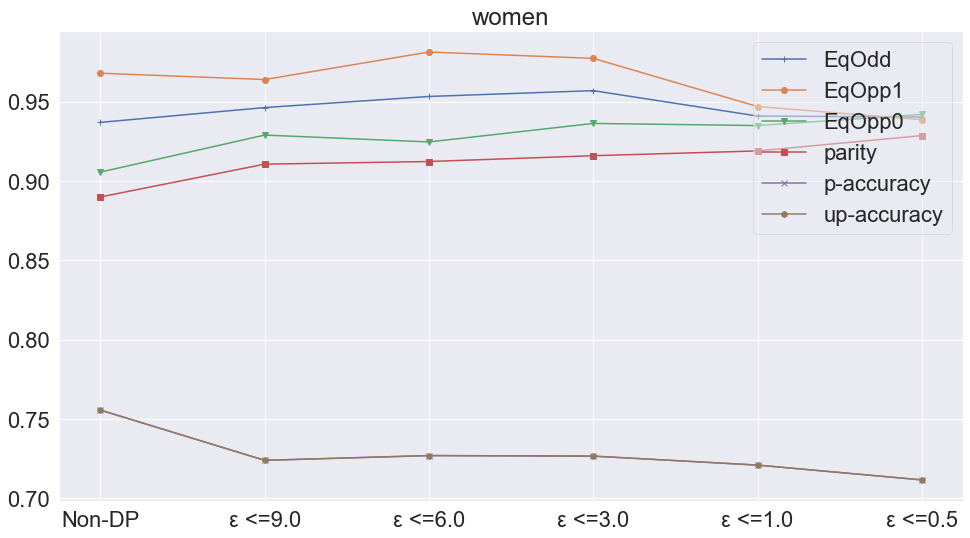

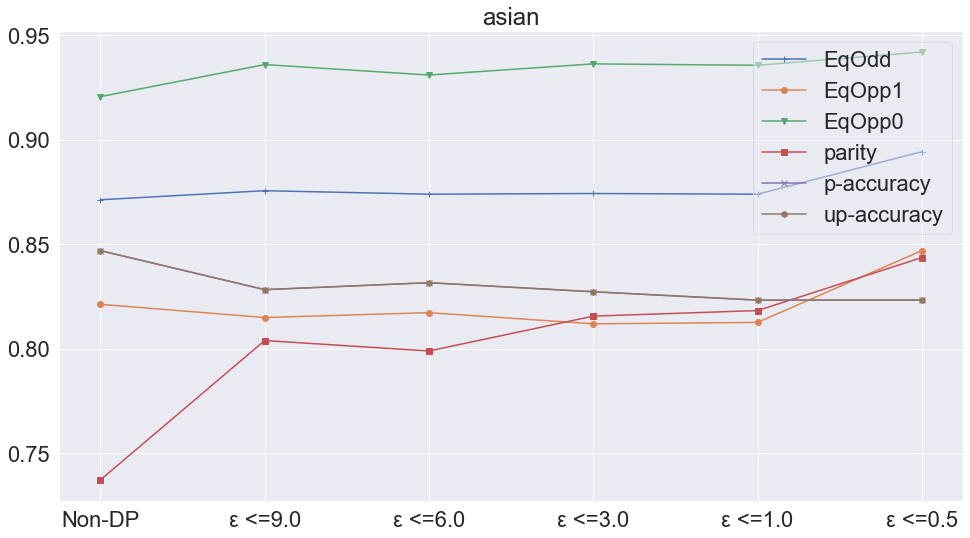

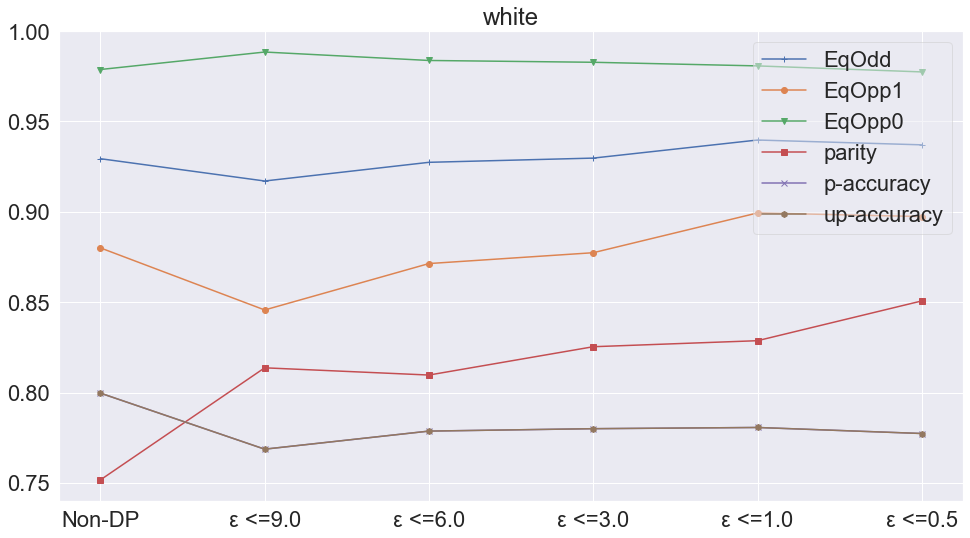

In [53]:
for identity in identities:
    plot_bias_metric(identity, identity)

### Race

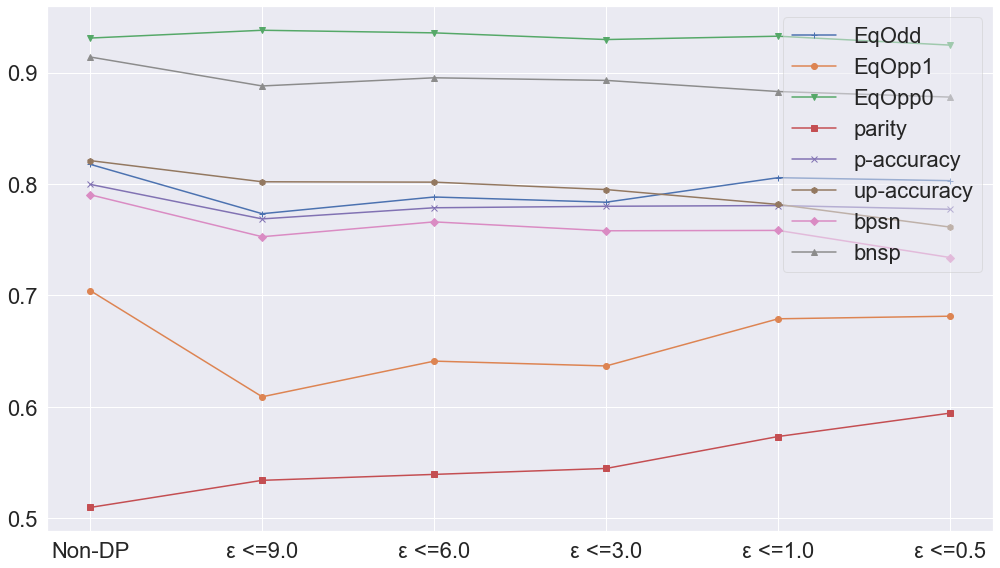

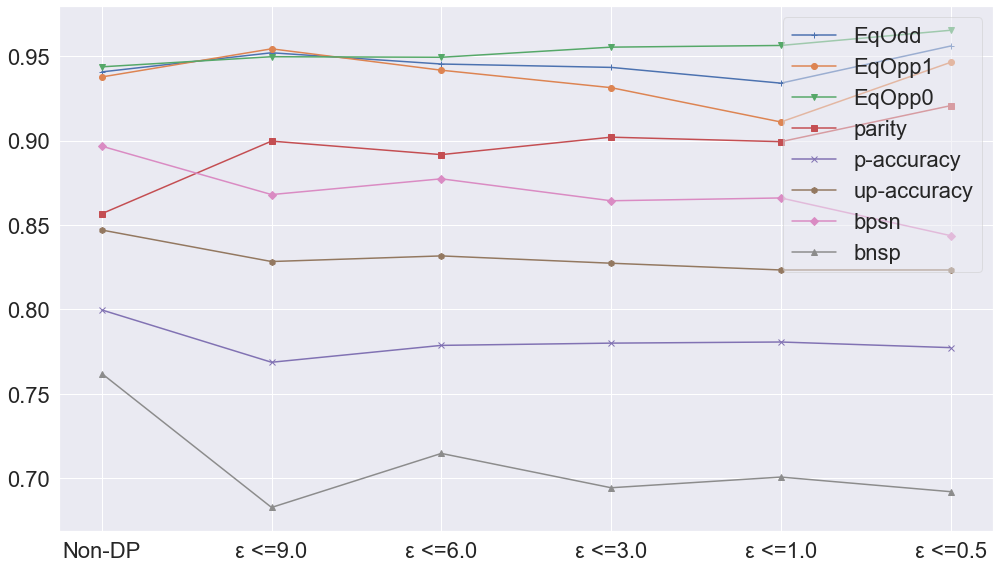

In [11]:
for category in ['white vs black', 'white vs asian']:
    plot_bias_metric(category, figure_name=f"racial_bias_{'_'.join(category.split())}.pdf")

### Gender

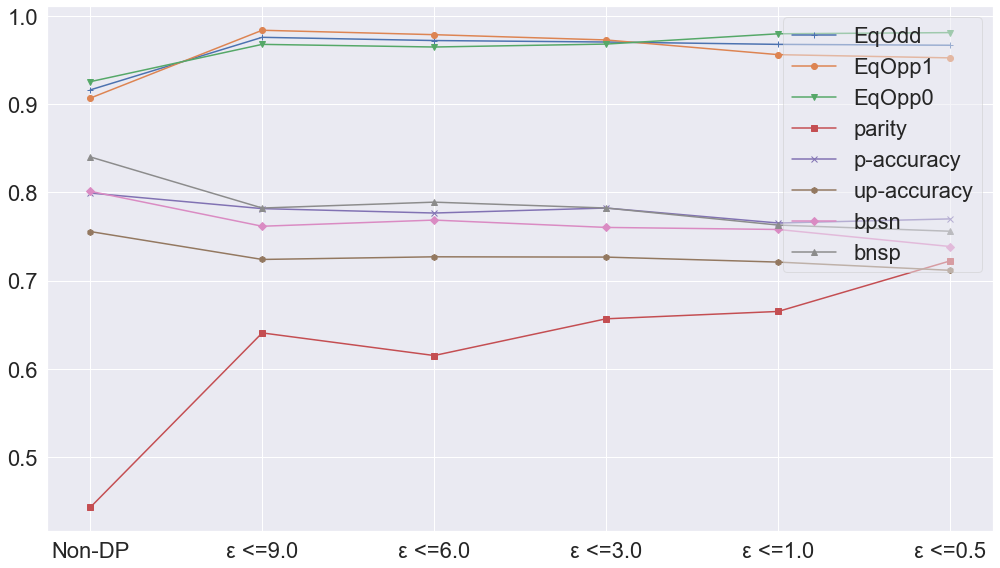

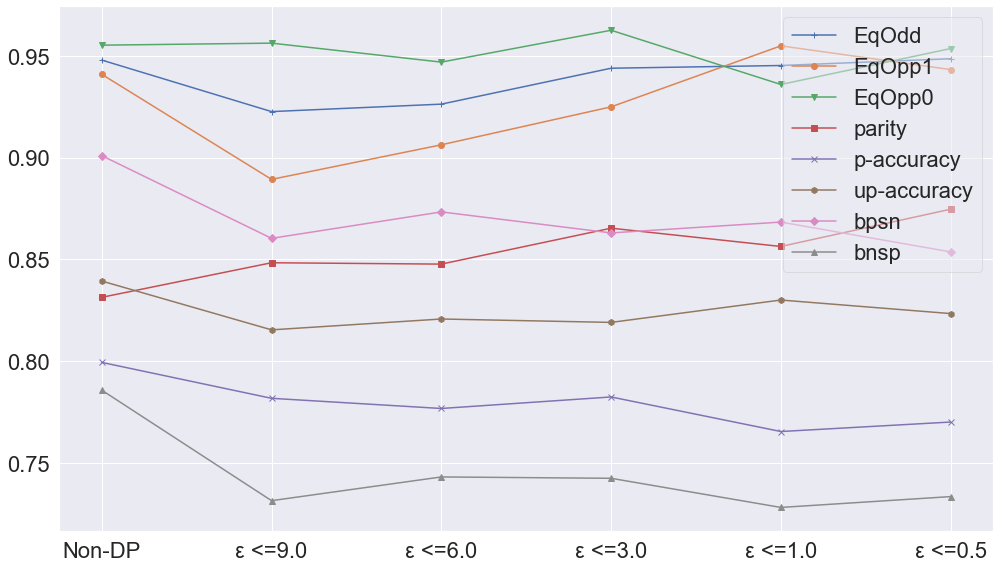

In [12]:
for category in ['men vs women', 'men vs transgender']:
    plot_bias_metric(category, figure_name=f"gender_bias_{'_'.join(category.split())}.pdf")